<img src="images/dqn.jpg" align=right width=25%></img>
# Deep Q-Learning
Author: Jin Yeom (jinyeom@utexas.edu)

## Contents
- [Configuration](#Configuration)
- [Environment](#Environment)
- [Replay memory](#Replay-memory)
- [Deep Q-network](#Deep-Q-network)
- [Training loop](#Training-loop)

This notebook is PyTorch implementation of Deep Q-Learning based on [this tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

In [101]:
from collections import namedtuple

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import gym
from gym import ObservationWrapper
from gym.spaces.box import Box
import torch
from torch import nn
from torch import optim
from torch import distributions
from torch.nn import functional as F
from torchvision import transforms
from torchsummary import summary
from baselines.common import atari_wrappers
from tqdm import tqdm_notebook as tqdm
from IPython import display

## Configuration

In [102]:
# random seed
SEED = 42
# OpenAI Gym environment name
ENV_NAME = "SpaceInvadersNoFrameskip-v4"
# stack size for Q-network input (input channels)
STACK_SIZE = 4
# screen size for the Q-network input
OBS_SIZE = 84
# batch sample size for training
BATCH_SIZE = 128
# discount factor (gamma)
GAMMA = 0.999
# start value of Gumbel-softmax temperature
TAU_INIT = 1.0
# annealing rate of Gumbel-softmax temperature
TAU_ANNEAL_RATE = 0.00003
# minimum value of Gumbel-softmax temperature
TAU_MIN = 0.5
# update rate of target network
TARGET_UPDATE = 10
# replay memory size
MEMORY_SIZE = 10000
# number of episodes of training
N_EPS = 100
# maximum number of iterations during an episode
N_ITERS = 10000

In [28]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)

device: cuda


## Environment

This section includes some preprocessing of observations from the Atari environment. This could have been very tedious, but [OpenAI's baseline implementation](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py) already provides preprocessing code for Atari environments. Thanks, OpenAI!

In [44]:
class TorchWrapper(ObservationWrapper):
    r"""ObservationWrapper that outputs torch.Tensor observation with the shape of (channels, height, width).
    NOTE: adopted from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr.
    """
    def __init__(self, env=None):
        super(TorchWrapper, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(self.observation_space.low[0, 0, 0],
                                     self.observation_space.high[0, 0, 0],
                                     [obs_shape[2], obs_shape[1], obs_shape[0]],
                                     dtype=self.observation_space.dtype)

    def observation(self, x):
        x = x.transpose(2, 0, 1)
        return torch.tensor(x, dtype=torch.float, device=DEVICE)

In [45]:
def render(state, obs_mean):
    display.clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("State")
    ax1.imshow(state)
    ax2.set_title("Observation (mean)")
    ax2.imshow(obs_mean)
    plt.pause(0.001)

In [46]:
def make_atari(env_id):
    env = atari_wrappers.make_atari(env_id)
    env = atari_wrappers.wrap_deepmind(env)
    env = TorchWrapper(env)
    env.seed(SEED)
    return env

Now, for some Jupyter magic! Let's take a look at what the agent sees.

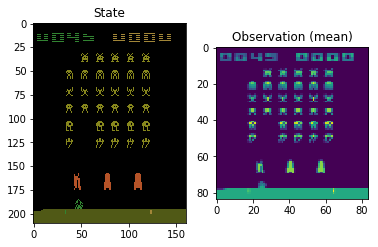

In [95]:
env = make_atari(ENV_NAME)
stacked_frames = [env.reset() for _ in range(STACK_SIZE)]

t = done = 0
while not done:
    if t % 10 == 0:
        state = env.render("rgb_array")
        obs_mean = sum(stacked_frames).squeeze()
        render(state, obs_mean)
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    stacked_frames.pop(0)
    stacked_frames.append(obs)
    t += 1

## Replay memory

In [48]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

In [49]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self._capacity = capacity
        self._memory = []
        self._position = 0
        
    def __len__(self):
        return len(self._memory)
        
    def push(self, *args):
        if len(self._memory) < self._capacity:
            self._memory.append(None) # make room for later
        self._memory[self._position] = Transition(*args)
        # if the memory is full, start pushing the beginning
        self._position = (self._position + 1) % self._capacity
        
    def sample(self, batch_size):
        return random.sample(self._memory, batch_size)

## Deep Q-network

Here, we're going to build the Q-network, based on the original architecture used in [DeepMind's Nature article](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).

In [50]:
class NatureDQN(nn.Module):
    def __init__(self, in_channels, act_dim):
        super(NatureDQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, act_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc4(x))
        return self.fc5(x)

In [99]:
act_dim = env.action_space.n
model = NatureDQN(STACK_SIZE, act_dim).to(DEVICE)
summary(model, (STACK_SIZE, OBS_SIZE, OBS_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
            Conv2d-2             [-1, 64, 9, 9]          32,832
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Linear-4                  [-1, 512]       1,606,144
            Linear-5                    [-1, 6]           3,078
Total params: 1,687,206
Trainable params: 1,687,206
Non-trainable params: 0
----------------------------------------------------------------


In [60]:
def sel_action(logit, t):
    tau = max(TAU_INIT * np.exp(-TAU_ANNEAL_RATE * t), TAU_MIN)
    act_probs = F.gumbel_softmax(logit, tau=tau)
    dist = distributions.Categorical(act_probs)
    return dist.sample()

In [87]:
# try getting a random action
print(sel_action(model(torch.randn(1, 4, 84, 84).to(DEVICE)), 0))

tensor([ 3], device='cuda:0')


## Training loop

In [103]:
def update(policy_net, target_net, memory):
    assert len(memory) >= BATCH_SIZE
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # TODO: finish implementation
    
    raise NotImplementedError

In [ ]:
def deep_q_learning():
    policy_net = NatureDQN().to(DEVICE)
    target_net = NatureDQN().to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    optimizer = optim.RMSProp(policy_net.parameters())
    memory = ReplayMemory(MEMORY_SIZE)
    
    for ep in tqdm(range(N_EPS)):
        obs = env.reset()
        t = done = 0
        while not done and t < N_ITERS:
            action = sel_action(policy_net(obs))
            next_obs, reward, done, _ = env.step(action)
            memory.push(obs, action, next_obs, reward)
            update(policy_net, target_net, memory)
            obs = next_obs
            t += 1
        if ep % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())